In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import sklearn
import urllib
import os

In [3]:
url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
file_name = 'green_tripdata_2015-09.csv'
# Download the September 2015 dataset
if os.path.exists(file_name): # Check whether we already get the data
    data = pd.read_csv(file_name)
else: # If not, download and save
    data = pd.read_csv(url)
    data.to_csv(url.split('/')[-1])

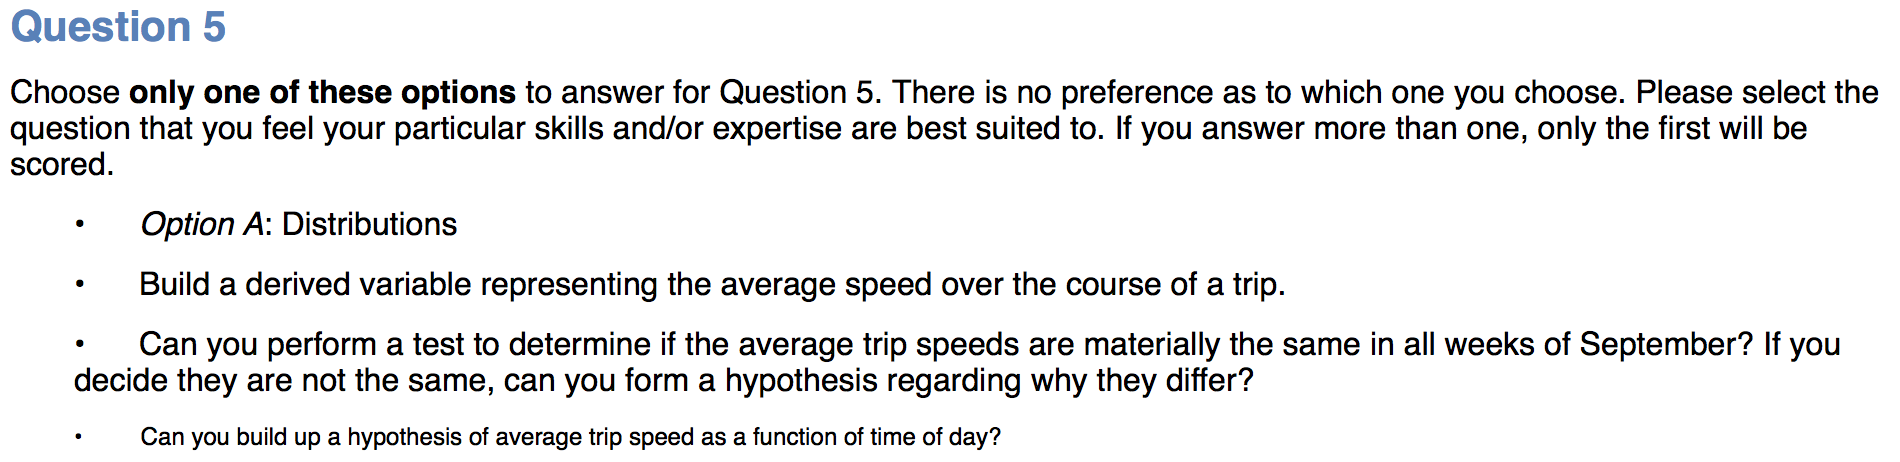

## 5.1 Build a derived variable representing the average speed over the course of a trip
<font size = 4>Drop trips whose trip duration less than 60 seconds.

In [4]:
def average_speed(df):
    
    df['Trip_duration'] = (pd.to_datetime(df.Lpep_dropoff_datetime)
                -pd.to_datetime(df.lpep_pickup_datetime)).dt.total_seconds()
    df = df[df.Trip_duration>60]
    df['average_speed'] = round(3600*df['Trip_distance']/df.Trip_duration, 1)
    df['Week'] = pd.to_datetime(df.lpep_pickup_datetime).apply(lambda x: x.week)
    
    return df

In [5]:
data = average_speed(data)

/Users/youyang/virtualenvs/AML/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/youyang/virtualenvs/AML/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [6]:
data.average_speed.describe()

count    1.469390e+06
mean     1.296177e+01
std      7.370256e+00
min      0.000000e+00
25%      9.400000e+00
50%      1.180000e+01
75%      1.510000e+01
max      3.479400e+03
Name: average_speed, dtype: float64

In [7]:
data = data[data.average_speed<40]

## 5.2 Perform a test to determine if the average trip speeds are materially the same in all weeks of September
<font size = 4> Hypothesis test

In [8]:
data.Week.value_counts()

37    357333
38    353210
39    332476
36    293348
40    129587
Name: Week, dtype: int64

In [9]:
week_36 = data[data.Week==36].average_speed
week_37 = data[data.Week==37].average_speed
week_38 = data[data.Week==38].average_speed
week_39 = data[data.Week==39].average_speed
week_40 = data[data.Week==40].average_speed

<font size = 4>Let $v_{36}, v_{37}, v_{38}, v_{39}, v_{40}$ represent the mean average speed of trips in week 36, 37, 38, 39, 40. $v$ represents mean average speed of trips in September

$H_0 : v_{36}= v_{37}= v_{38}= v_{39}= v_{40}$ 

$H_1:$ Not all of  $v_{36},v_{37}, v_{38}, v_{39}, v_{40}$ are equal.

With significance level $\alpha = 0.05$, we will reject $H_0$ when p<0.05 

In [10]:
import scipy.stats
scipy.stats.f_oneway(week_36,week_37, week_38,week_39, week_40)

F_onewayResult(statistic=1098.8334716731972, pvalue=0.0)

<font size = 4>p = 0.0 <0.05. we should reject null hypothesis. Speed are not same in all weeks in September.

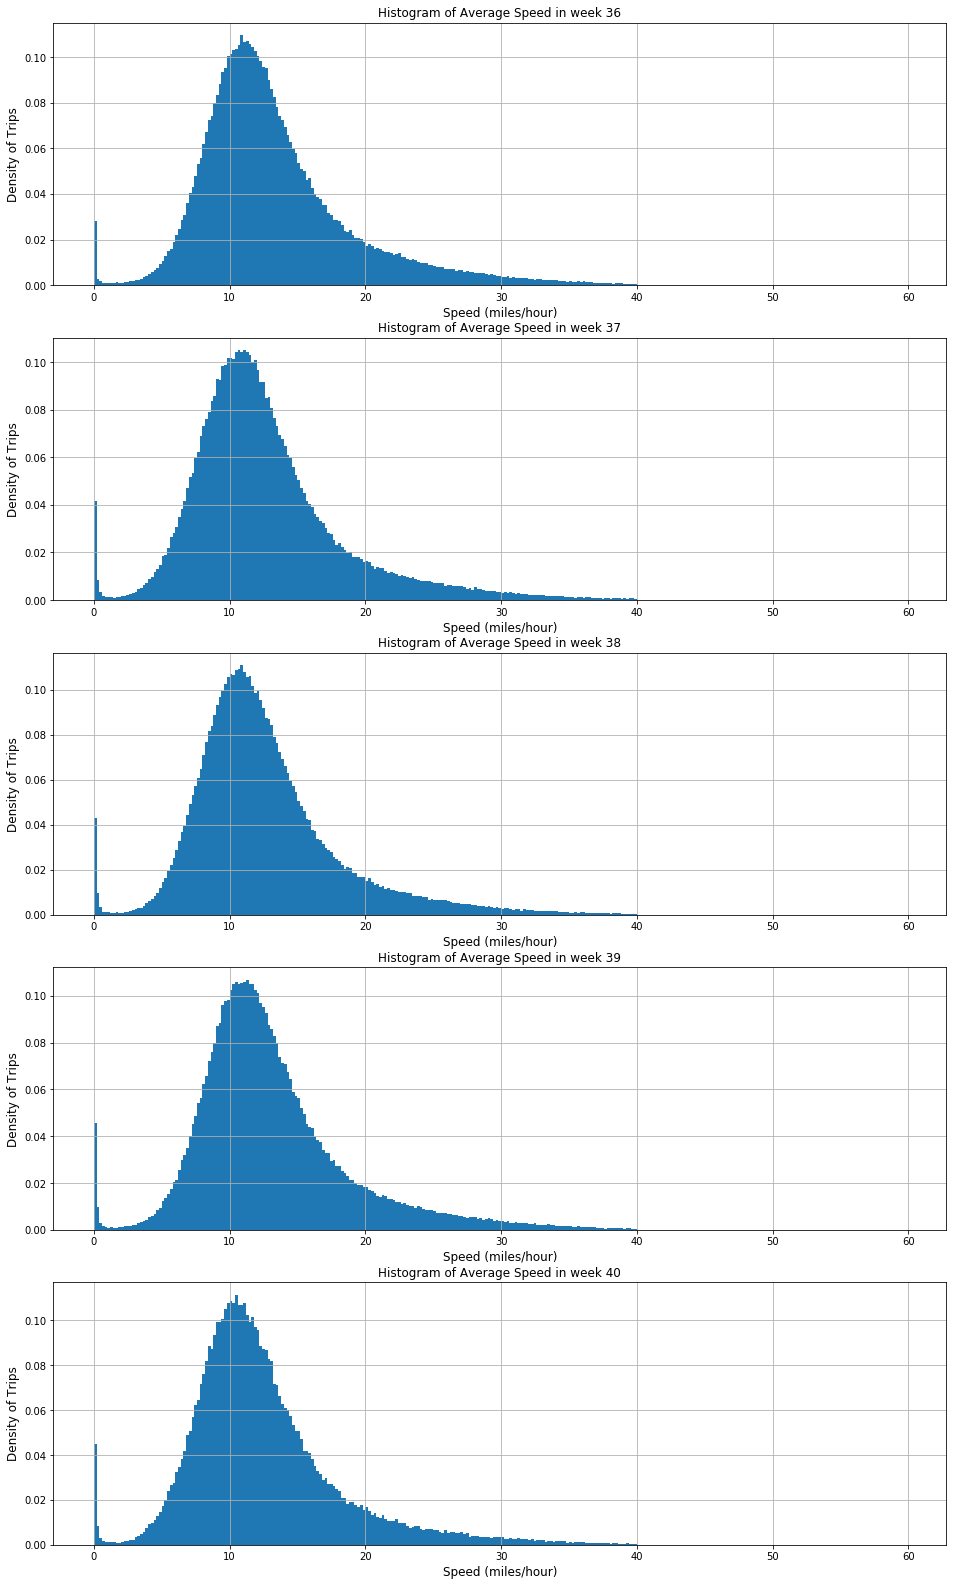

In [11]:
week_list = [week_36,week_37,week_38,week_39,week_40]
fig, ax = plt.subplots(5,1,figsize = (16,28)) 
break_points = [i/5 for i in range(300)]
# Plot whole histgram
for i in range(5):
    week_list[i].hist(ax = ax[i],normed = True, bins = break_points)
    ax[i].plot()
    ax[i].set_xlabel('Speed (miles/hour)', size = 12)
    ax[i].set_ylabel('Density of Trips', size = 12)
    ax[i].set_title('Histogram of Average Speed in week {n}'.format(n = 36+i), size =12 )

In [12]:
for i in range(5):
    print('mean of week', 36+i, ':', 
          week_list[i].mean(),'\n',
          'number of transactions', 36+i, ':',
          len(week_list[i]))

mean of week 36 : 13.30395946111785 
 number of transactions 36 : 293348
mean of week 37 : 12.6286433103016 
 number of transactions 37 : 357333
mean of week 38 : 12.63513632116871 
 number of transactions 38 : 353210
mean of week 39 : 13.094489226290019 
 number of transactions 39 : 332476
mean of week 40 : 12.434410087431608 
 number of transactions 40 : 129587


<font size = 4>Speed in week 37 and 38 is relatively low and the number of transactions are relatively high( There are only six days in week 36, and 3 days in week 40). We assume there are more people attending to take taxi and more traffic jams during week 37 and 38. For instance, most students come back to school from other state may result in large amount of taxi get stuck when they enter manhattan island. We could dive into trips that from airports to manhattan to justify our hypothesis.

## 5.3 Build up a hypothesis of average trip speed as a function of time of day

In [13]:
data['Pickup_hour'] = pd.to_datetime(data.lpep_pickup_datetime).apply(lambda x: x.hour)
data['Pickup_day'] = pd.to_datetime(data.lpep_pickup_datetime).apply(lambda x: x.day)

In [14]:
# Get the pick up hour of a trip
# Caculate the mean speed by hour
trip_mean = data.average_speed.mean()
table = data.pivot_table(values = 'average_speed', index = 'Pickup_day', 
                         aggfunc = [np.mean])
table.columns = ['Mean of average speed']
print('The table of trip distance by hour of day')
table

The table of trip distance by hour of day


,Mean of average speed
Pickup_day,
1,12.735211
2,12.773937
3,12.521339
4,12.929363
5,14.031493
6,14.472192
7,14.612989
8,12.386371
9,11.822580


Text(0,0.5,'Speed (miles/ hour)')

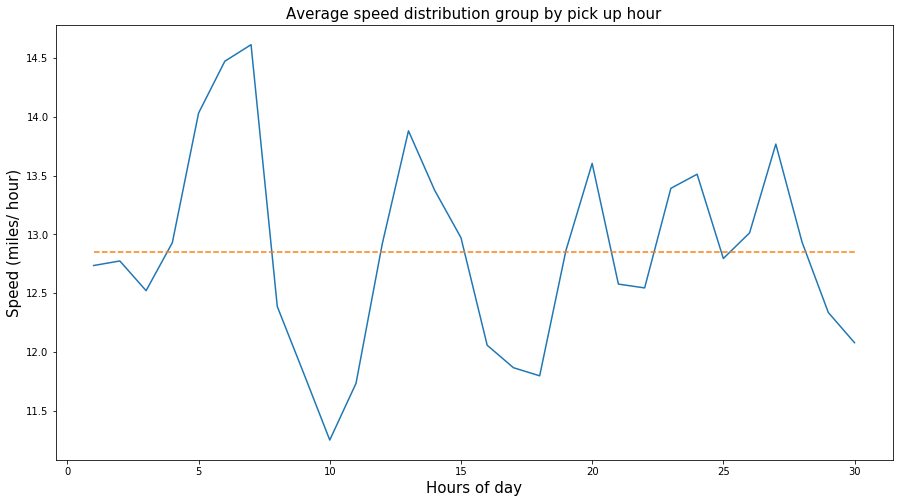

In [15]:
# Plot it
f, ax = plt.subplots(figsize = (15,8))
line1, = ax.plot(table.index, table['Mean of average speed'])
line3, = ax.plot(table.index, [trip_mean]*30,'--')
plt.title('Average speed distribution group by pick up hour',size = 15)
plt.xlabel('Hours of day',size = 15)
plt.ylabel('Speed (miles/ hour)',size = 15)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
X = data[['Pickup_day']]
y = data.average_speed

pf = PolynomialFeatures(degree=11)
X_fit = pf.fit_transform(X)
lrModel = LinearRegression()
lrModel.fit(X_fit,y)
lrModel.score(X_fit,y)

/Users/youyang/virtualenvs/AML/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.007626966112150079

Text(0,0.5,'Speed (miles/ hour)')

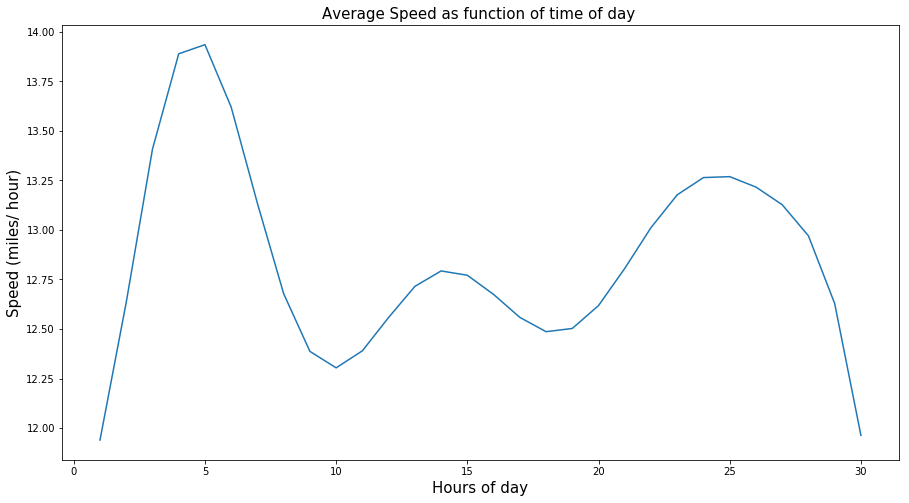

In [17]:
date =[i for i in range(1,31)]
X = pd.DataFrame(date)
X_fit_predict = pf.transform(X)
y_predict = lrModel.predict(X_fit_predict)
f, ax = plt.subplots(figsize = (15,8))
line1, = ax.plot(date, y_predict)
plt.title('Average Speed as function of time of day ',size = 15)
plt.xlabel('Hours of day',size = 15)
plt.ylabel('Speed (miles/ hour)',size = 15)

In [18]:
lrModel.coef_

array([ 0.00000000e+00,  4.20145764e-02,  1.20816544e-01,  1.65685397e-01,
       -8.64131425e-02,  1.69911068e-02, -1.80546053e-03,  1.15461999e-04,
       -4.58476174e-06,  1.10888251e-07, -1.49849188e-09,  8.68473821e-12])

So the function is 11-orderd function. Coefficients are above.